# Precomputed knn
The purpose of thos notebook is to first, verify that the proposed precomputed_knn feature functions properly and second, display some possible use cases for it

## Functionality Tests
We will begin by verifying that the new feature actually functions as designed and doesn't interfere with the normal UMAP algorithm. For that we will first create some test data. 

We ensure that our data has three distinct random blobs to make it easier to evaluate the UMAP embeddings later. Furthermore our test data will have 5100 samples as that is just above the threshold for "small data".

In [1]:
import numpy as np
import umap
from umap.umap_ import nearest_neighbors
from scipy.spatial import distance_matrix
import timeit
import sklearn



y = np.random.rand(1700, 60)
X = np.concatenate((y+20, y, y-20))
X_dm = distance_matrix(X, X)

X_small = X[:1000]
X_small_dm = X_dm[:1000, :1000]

Now, let's use UMAP's internal knn function to precompute the knn for k=50 and see how we can train a UMAP object with it.

In [2]:
random_state = 10

knn = nearest_neighbors(
                        X, 
                        n_neighbors=50,
                        metric='euclidean',
                        metric_kwds=None,
                        angular=False,
                        random_state=random_state,
                        )

knn_dm = nearest_neighbors(
                           X_dm, 
                           n_neighbors=50,
                           metric='precomputed',
                           metric_kwds=None,
                           angular=False,
                           random_state=random_state,
                           )

knn_small = nearest_neighbors(
                              X_small, 
                              n_neighbors=50,
                              metric='euclidean',
                              metric_kwds=None,
                              angular=False,
                              random_state=random_state,
                              )

In [3]:
print("\033[1m"+"Time taken to run UMAP without precomputed_knn:\033[0m")
%time normal_umap = umap.UMAP(n_neighbors=50, random_state=random_state).fit(X)
print("\n\033[1m"+"Time taken to run UMAP with precomputed_knn:\033[0m")
%time knn_umap = umap.UMAP(n_neighbors=50, precomputed_knn=knn, random_state=random_state).fit(X)

# We also run second iterations to check for reproducibility
knn_umap2 = umap.UMAP(n_neighbors=50, precomputed_knn=knn, random_state=random_state).fit(X)
normal_umap2 = umap.UMAP(n_neighbors=50, random_state=random_state).fit(X)

normal_embedding = normal_umap.embedding_
knn_embedding = knn_umap.embedding_
normal_embedding2 = normal_umap2.embedding_
knn_embedding2 = knn_umap2.embedding_

Time taken to run UMAP without precomputed_knn:
Wall time: 17.4 s

Time taken to run UMAP with precomputed_knn:
Wall time: 15.6 s


As expected the precomputed_knn is slightly faster than the normal UMAP embedding. For a small dataset and low values of n_neighbors like these ones, the benefits are marginal. However, later on, we will see how the precomputed_knn can save us a lot of time when analyzing large datasets.

Are the embeddings for knn_umap and knn_umap2 the same?
True
Are the embeddings for normal_umap and normal_umap2 the same?
True
Are the embeddings for normal_umap and knn_umap the same?
True


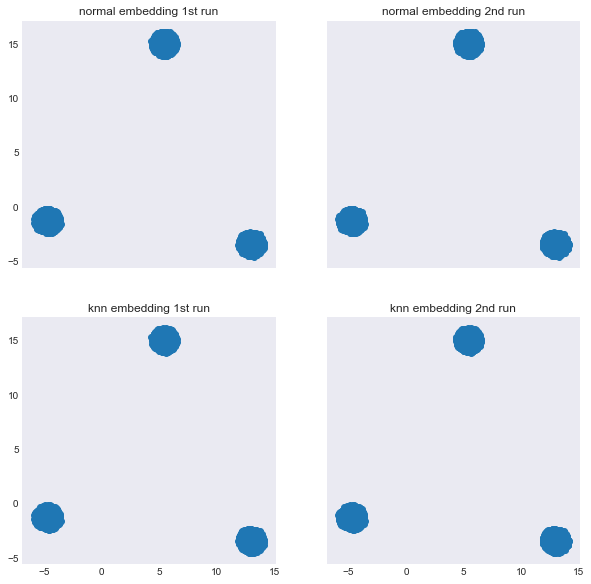

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
axs[0,0].scatter(normal_embedding[:, 0], normal_embedding[:, 1])
axs[0,1].scatter(normal_embedding2[:, 0], normal_embedding2[:, 1])
axs[1,0].scatter(knn_embedding[:, 0], knn_embedding[:, 1])
axs[1,1].scatter(knn_embedding2[:, 0], knn_embedding2[:, 1])
axs[0,0].set_title("normal embedding 1st run")
axs[0,1].set_title("normal embedding 2nd run")
axs[1,0].set_title("knn embedding 1st run")
axs[1,1].set_title("knn embedding 2nd run")
plt.show

print("\033[1m"+"Are the embeddings for knn_umap and knn_umap2 the same?\033[0m")
print((knn_embedding == knn_embedding2).all())

print("\033[1m"+"Are the embeddings for normal_umap and normal_umap2 the same?\033[0m")
print((normal_embedding2 == normal_embedding).all())

print("\033[1m"+"Are the embeddings for normal_umap and knn_umap the same?\033[0m")
print((knn_embedding == normal_embedding).all())

So with the additional modification of declaring the random state later in the fit() function we see that we can create reproducible results. Setting the random_seed variable later doesn't affect the code much. If the user inputs something that can't be used to set a random seed then NNDescent's check_random_state() will catch the error. In any case, we could verify this input in the _validate_parameter method.

However, we note that it is only reproducible if the k in the precomputed_knn is the same as n_neighbors. This is due to the fact that, when using NNDescent, a k-nn matrix pruned to only include m neighbors (m<k) will not be equal to an m-nn matrix computed seperately.

### Input Validation
Let's see how precomputed_knn deals with being fed improper inputs.

In [5]:
# We use a filter to make UserWarning an exception so we can catch it.
# This is just done so that we can more easily print the error.
import warnings
warnings.simplefilter('error', UserWarning)

In [6]:
# mismatched knn_dist and knn_indices
try:
    test = umap.UMAP(precomputed_knn=(knn[0],knn[1][:-1],knn[2]))
    test.fit(X)
except ValueError as error:
    print("\033[1m"+"mismatched knn_dist and knn_indices:\033[0m")
    print("ValueError: "+ str(error))

# knn_dist or knn_indices not arrays
try:
    a = 'not array'
    test = umap.UMAP(precomputed_knn=(a,knn[1][:-1],knn[2]))
    test.fit(X)
except ValueError as error:
    print("\n\033[1m"+"knn_indices not a numpy array:\033[0m")
    print("ValueError: "+ str(error))

try:
    a = 'not array'
    test = umap.UMAP(precomputed_knn=(knn[0],a,knn[2]))
    test.fit(X)
except ValueError as error:
    print("\n\033[1m"+"knn_dist not a numpy array:\033[0m")
    print("ValueError: "+ str(error))

# n_neighbors > k in precomputed_knn; remember that our original k is 50
try:
    test = umap.UMAP(precomputed_knn=knn, n_neighbors=51)
    test.fit(X)
except UserWarning as error:
    print("\n\033[1m"+"n_neighbors > k in precomputed_knn:\033[0m")
    print("UserWarning: "+ str(error))

# k in precomputed_knn > n_neighbors
test = umap.UMAP(precomputed_knn=knn, n_neighbors=25)
test.fit(X)
k_after_pruning = test._knn_dists.shape[1]
print("\n\033[1m"+"k in precomputed_knn > n_neighbors:\033[0m")
print("before pruning k={}\nafter pruning k={}".format(50, k_after_pruning))
    
# small n_samples; 4096 > n_samples
try:
    test = umap.UMAP(precomputed_knn=knn_small, n_neighbors=50)
    test.fit(X_small)
except UserWarning as error:
    print("\n\033[1m"+"small n_samples:\033[0m")
    print("UserWarning: "+ str(error))

# precomputed_knn with unique=True
try:
    test = umap.UMAP(precomputed_knn=knn, unique=True)
    test.fit(X)
except ValueError as error:
    print("\n\033[1m"+"precomputed_knn with unique:\033[0m")
    print("ValueError: "+ str(error))

# Data a different size than precomputed_knn
try:
    a = np.copy(X[:-1])
    test = umap.UMAP(precomputed_knn=knn, n_neighbors=50)
    test.fit(a)
except UserWarning as error:
    print("\n\033[1m"+"Data a different size than precomputed_knn:\033[0m")
    print("UserWarning: "+ str(error))
    
# knn search index is wrong type
try:
    a = 'not array'
    test = umap.UMAP(precomputed_knn=(knn[0],knn[1],a))
    test.fit(X)
except ValueError as error:
    print("\n\033[1m"+"knn_search_index is wrong type:\033[0m")
    print("ValueError: "+ str(error))

mismatched knn_dist and knn_indices:
ValueError: precomputed_knn[0] and precomputed_knn[1] must be numpy arrays of the same size.

knn_indices not a numpy array:
ValueError: precomputed_knn[0] must be ndarray object.

knn_dist not a numpy array:
ValueError: precomputed_knn[1] must be ndarray object.

n_neighbors > k in precomputed_knn:

k in precomputed_knn > n_neighbors:
before pruning k=50
after pruning k=25

small n_samples:

precomputed_knn with unique:
ValueError: unique is not currently available for precomputed_knn.

Data a different size than precomputed_knn:

knn_search_index is wrong type:
ValueError: precomputed_knn[2] (knn_search_index) must be an NNDescent object.


There are other things that we could check for to make sure that the input is actually a proper precomputed_knn. For example, the knn_dists have to be ordered. However, this is probably not worth it and at some point we just have to trust the user.

## Practical Uses

### Trying UMAP with various parameters
Let's look at how we can use precomputed_knn to save time. First we will test it out on MNIST which has 70,000 samples of 784 dimensions. If we want to test out a series of n_neighbors parameters we might lose quite a bit of time recomputing the knn matrices for our data. Instead, we can compute the knn for the largest n_neighbors we wish to analyze and then feed that to precomputed_knn to UMAP. UMAP will automatically prune it to the right n_neighbors value and skip the neareast neighbors step, saving us a lot of time.

We note that we don't use a random state in order to leverage UMAP's parallelization and speed up the calculations.

In [7]:
from sklearn.datasets import fetch_openml

data, labels = sklearn.datasets.fetch_openml(
                'mnist_784', version=1, return_X_y=True
)
labels = np.asarray(labels, dtype=np.int32)

n_neighbors = [5, 50, 100, 250]
min_dists = [0, 0.2, 0.5, 0.9]
normal_embeddings = np.zeros((4, 4, 70000, 2))
precomputed_knn_embeddings = np.zeros((4, 4, 70000, 2))

In [8]:
%%time
# UMAP run on the grid of parameters without precomputed_knn
for i, k in enumerate(n_neighbors):
    for j, dist in enumerate(min_dists):
        normal_embeddings[i, j] = umap.UMAP(n_neighbors=k,
                                            min_dist=dist,
                                           ).fit_transform(data)
print("\033[1m"+"Time taken to compute UMAP on grid of parameters:\033[0m")

Time taken to compute UMAP on grid of parameters:
Wall time: 28min 14s


In [27]:
%%time
# UMAP run on list of n_neighbors without precomputed_knn

# We compute the knn for max(n_neighbors)=250
mnist_knn = nearest_neighbors(data,
                              n_neighbors=250,
                              metric="euclidean",
                              metric_kwds=None,
                              angular=False,
                              random_state=None,
                             )
# Now we compute the embeddings for the grid of parameters
for i, k in enumerate(n_neighbors):
    for j, dist in enumerate(min_dists):
        precomputed_knn_embeddings[i, j] = umap.UMAP(n_neighbors=k,
                                                      min_dist=dist,
                                                      precomputed_knn=mnist_knn,
                                                      ).fit_transform(data)
print("\033[1m"+"Time taken to compute UMAP on grid of parameters with precomputed_knn:\033[0m")

Time taken to compute UMAP on grid of parameters with precomputed_knn:
Wall time: 17min 6s


Using a precomputed_knn we have cut the computation time in half! Observe that half of our n_neighbors values are relatively small. If instead, we had had a higher distribution of values, the time savings would have been even greater.

With this, we can easily visualize how the n_neighbors parameter affects our embedding.

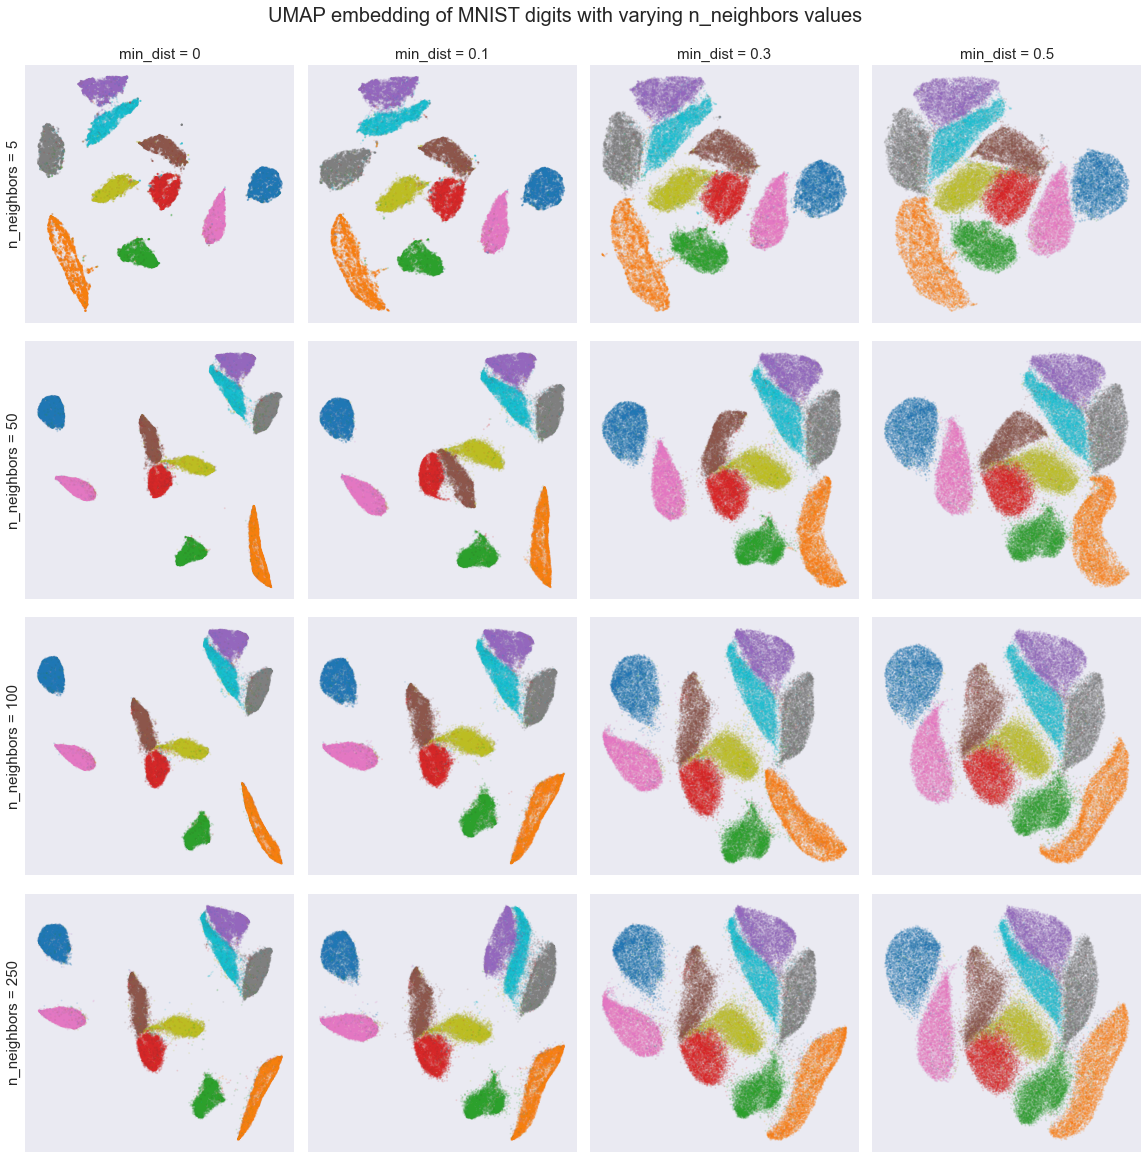

In [39]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        ax.scatter(precomputed_knn_embeddings[i, j, :, 0],
                   precomputed_knn_embeddings[i, j, :, 1],
                   c=labels/9,
                   cmap='tab10',
                   alpha=0.1,
                   s=1,
                   )
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title("min_dist = {}".format(min_dists[j]), size=15)
        if j == 0:
            ax.set_ylabel("n_neighbors = {}".format(n_neighbors[i]), size=15)
fig.suptitle("UMAP embedding of MNIST digits with varying n_neighbors values", y=0.92, size=20)
plt.subplots_adjust(wspace=0.05, hspace=0.07)

We see that in this case, the embedding is robust to the choice of n_neighbors and that lower min_dist values simply pack the clsuters together.

### Analyzing knn distribution before UMAP

Another sitution where precomputed_knn could be beneficial is if you wish to use UMAP but already obtained the k-nn previously.